# Intro
This notebook is part of a mini-series that aims to build a simple RAG system for learning purposes.

This notebook assumes:
- we have a dataset available of chunks of text data to index `chunk_id (int) | text_chunk (str)`.
- Optionally, (but really importantly, if we'd like to go beyond the first section and evaluate our retriever model), it also assumes we have a dataset of questions which can be answered by looking at information in specific chunk_ids (to simplify, we'll assume there's only one relevant chunk_id) in the form `question (str) | answer (str) | relevant_chunk_id (int)`

Plan:
- The first section loads an embedder model and maps it to the dataset of text chunks.
- The second section evaluates the (dummy) solution explored in the first section using the dataset of questions.
- The third section tries to improve the solution explored in the first section by fine-tuning our model on the questions dataset.

In [1]:
import os

import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from datasets import load_from_disk, concatenate_datasets
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
)
from sentence_transformers.losses import CosineSimilarityLoss



import faiss

LOCAL_DATASET_FOLDER = "local_datasets"

# Load datasets

In [2]:
CORPUS_DATASET_NAME = "wiki-data-chunked-recursive-CS300"
QUESTIONS_DATASET_NAME = "wiki-data-chunked-recursive-CS300-questions-llm"

In [3]:
# The dataset was created in the previous notebook
# Contains:
#  A: An extract of some english wikipedia articles
#  B: A list of crowdsourced questions/answers pairs and the relevant article that contains the answer.
ds_corpus = load_from_disk(os.path.join(LOCAL_DATASET_FOLDER, CORPUS_DATASET_NAME))
ds_qas = load_from_disk(os.path.join(LOCAL_DATASET_FOLDER, QUESTIONS_DATASET_NAME))

In [4]:
ds_corpus

Dataset({
    features: ['id', 'url', 'title', 'original_id', 'text_chunk'],
    num_rows: 271938
})

In [5]:
ds_qas

Dataset({
    features: ['chunk_id', 'question', 'answer'],
    num_rows: 96
})

# Section 1: Dummy straightforward solution
(i.e map an embedding model over the whole dataset)

In [6]:
# The notebook series uses the miniLM model to create embeddings for questions.
# However, in this notebook, we show how we could have done it with BERT as well.
# (the other notebooks will expect MiniLM embeddings though)
def retrieve_bert_embedding(bert_model, text_batch):
    # We operate one text input at the time for simplicity.
    # Using batches would be faster, but this implies padding inputs so they are all the same size and using attention masks properly.
    encoded_inputs = tokenizer(text_batch, return_tensors='pt')

    # The input needs to be < 512 tokens long otherwise the model call will crash
    output = bert_model(**encoded_inputs)

    # We use the pooler_output as embedding layer. It contains an embedding obtained for the [CLS] token added at
    # the beginning.
    # An alternative would be to retrieve multiple hidden embedding states and use those instead (by concatenating multiple layers),
    # it might contain more semantic meaning at the expense of being a bigger vector. I would recommend to try both.
    return torch.nn.functional.normalize(output.pooler_output) # Normalise as this will help for indexing, and doesn't change Cosine similarities

def retrieve_minilm_embedding(mini_lm_model, text_batch):
    embedding = torch.Tensor(mini_lm_model.encode(text_batch))

    return embedding # MiniLM embeddings are already normalised

# [Exercise]: Feel free to implement a different embedding retrieval method!
# Some inspiration of Embedding models to use: https://huggingface.co/spaces/mteb/leaderboard

In [7]:
model_to_use = "MiniLM" # you can replace with "BERT"

In [8]:
if model_to_use == "MiniLM":
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    retrieve_embedding_method = retrieve_minilm_embedding
elif model_to_use == "BERT":
    # More info on BERT: https://huggingface.co/blog/bert-101
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained("bert-base-uncased")
    retrieve_embedding_method = retrieve_bert_embedding

model.eval()
    
# switch to GPU if you have one available
device = "cpu"
model.to(device)

/Users/pierret/.pyenv/versions/3.10.1/envs/transformers_playground/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [9]:
if model == "BERT":
    # Play with the tokeniser a bit, note the added tokens and the casing dropped
    # Always check intermediate inputs!
    tokenizer.decode(tokenizer("Hi! nice to meet you", return_tensors='pt')["input_ids"][0])

In [10]:
# quickly check that we can capture semantic similarity
cos_sim = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

embedding_food = retrieve_embedding_method(model, "I like to eat ice creams and donuts.")
embedding_food2 = retrieve_embedding_method(model, "My favourite food is gelato, and sugar pastries.")
embedding_history_lesson = retrieve_embedding_method(model, "Napoleon III was a popular monarch who oversaw the modernization of the French economy.")
embedding_fra = retrieve_embedding_method(model, "BERT n'a pas été entrainé avec du Français.")
embedding_trap = retrieve_embedding_method(model, "This road is shaped like a donut.") # Contains the same word in a different context

print(f"{cos_sim(embedding_food, embedding_food2)=}")
print(f"{cos_sim(embedding_food, embedding_history_lesson)=}")
print(f"{cos_sim(embedding_food, embedding_fra)=}")
print(f"{cos_sim(embedding_food, torch.randn(embedding_food.shape[0]))=}")
print(f"{cos_sim(embedding_food, embedding_trap)=}")
# Some results might be a bit surprising for some models, but at least the most similar vectors are the expected ones

cos_sim(embedding_food, embedding_food2)=tensor(0.5597)
cos_sim(embedding_food, embedding_history_lesson)=tensor(0.1039)
cos_sim(embedding_food, embedding_fra)=tensor(0.0042)
cos_sim(embedding_food, torch.randn(embedding_food.shape[0]))=tensor(0.0327)
cos_sim(embedding_food, embedding_trap)=tensor(0.2990)


In [11]:
ds_corpus = ds_corpus.map(
    lambda element: {"embedding": retrieve_embedding_method(model, element["text_chunk"])},
    batched=True
)

In [12]:
ds_qas = ds_qas.map(
    lambda element: {"embedding": retrieve_embedding_method(model, element["question"])},
    batched=True
)

In [14]:
# And that's already done! We can save it for indexing later on...But how good are these embeddings really?
# We'll investigate this now
ds_corpus.save_to_disk(
    os.path.join(LOCAL_DATASET_FOLDER, CORPUS_DATASET_NAME + "with_simple_embeddings")
)

ds_qas.save_to_disk(
    os.path.join(LOCAL_DATASET_FOLDER, QUESTIONS_DATASET_NAME + "with_simple_embeddings")
)

Saving the dataset (0/2 shards):   0%|          | 0/271938 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/96 [00:00<?, ? examples/s]

# Section 2: Evaluation
We'd like to know if our embeddings capture the semantic meaning of passages well enough so that,
for each question/answer pair in our questions dataset, we can retrieve the right document
by embedding the question input and running a nearest-neighbour search over the dataset... BUT
this implies we have our indexing solution ready to use already.

We'll try:
- to evaluate the quality of the embeddings without actually running a kNN search
- evaluate the whole retrieval process by using a very simple kNN search method (which works here because the dataset is really small)

In [15]:
# Optionally reload datasets previously checkpointed
ds_corpus = load_from_disk(
    os.path.join(LOCAL_DATASET_FOLDER, CORPUS_DATASET_NAME + "with_simple_embeddings")
)

ds_qas = load_from_disk(
    os.path.join(LOCAL_DATASET_FOLDER, QUESTIONS_DATASET_NAME + "with_simple_embeddings")
)

## A) Quality of embeddings without kNN search

In [16]:
# For each question,
# without running an actual kNN search, we can simply compare the cosine similarity between:
# - the question embedding / target document embedding
# - the question embedding / other random documents which are not target
# .. and check that the target embedding is usually much closer. That'd be a good indicator that embeddings are working as expected
# but will not inform us onthe exact performance of the whole retrieval process.
def compare_question_embedding_to_target_embedding(model, question_element):
    question_embedding = retrieve_embedding_method(model, question_element["question"])
    target_id = question_element["chunk_id"] # corresponds to the exact id in ds_corpus
    rnd_id = np.random.randint(len(ds_corpus))

    target_embedding = retrieve_embedding_method(model, ds_corpus[target_id]["text_chunk"])
    random_doc_embedding = retrieve_embedding_method(model, ds_corpus[rnd_id]["text_chunk"])

    return {
        "target_emb_similarity": cos_sim(question_embedding, target_embedding),
        "random_emb_similarity": cos_sim(question_embedding, random_doc_embedding)
    }

ds_qas = ds_qas.map(
    lambda element: compare_question_embedding_to_target_embedding(model, element)
)

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

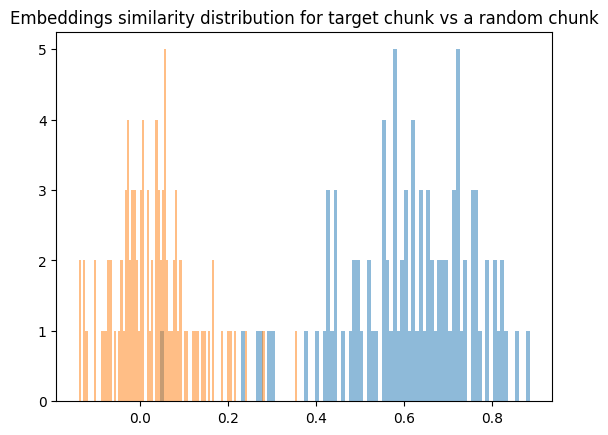

In [17]:
plt.hist(ds_qas["target_emb_similarity"], bins=100, alpha=0.5)
plt.hist(ds_qas["random_emb_similarity"], bins=100, alpha=0.5)
plt.title("Embeddings similarity distribution for target chunk vs a random chunk")
plt.show()

In [18]:
# If the histograms are fairly well separated, we can say the embeddings are working as intended, but that doesn't
# mean we'll retrieve the right documents everytime. To check this we'll need to actual run the kNN search.

## B) Exact evaluation with kNN search

In [19]:
# We will borrow a few things from the next notebook here that dives into more details on the different indexing methods we can use.

In [20]:
all_vectors = np.array(ds_corpus["embedding"])

# Build index
d = len(ds_corpus[0]["embedding"])
flat_index = faiss.IndexFlatIP(d)
flat_index.add(all_vectors)

In [21]:
def compare_chunk_retrieved_to_target(model, index, question_element):
    question_embedding = retrieve_embedding_method(model, question_element["question"])
    target_id = question_element["chunk_id"] # corresponds to the exact id in ds_corpus
    
    query = question_embedding.numpy()[np.newaxis, :]

    distances, retrieved_ids = index.search(query, 1)

    return {
        "found_right_match": target_id == retrieved_ids[0][0],
    }

In [22]:
ds_qas = ds_qas.map(
    lambda element: compare_chunk_retrieved_to_target(model, flat_index, element)
)

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

In [23]:
accuracy_top_result = sum(ds_qas['found_right_match']) / len(ds_qas)
print(f"We retrieved the right document in {sum(ds_qas['found_right_match'])} of {len(ds_qas)} cases")
print(f"Accuracy top result: {accuracy_top_result:.2f}")

# [Exercise] We are assuming only one context chunk is relevant here and we return only one, which
# makes the evaluation metric quite straightforward. How would that change if multiple text chunks
# could be considered as relevant? What about if we return multiple? (Look closer to a multi-class
# multi-label ML problem)

We retrieved the right document in 52 of 96 cases
Accuracy top result: 0.54


In [24]:
# [Exercise]: what about checking Recall @ top 3 results?
# [Exercise]: can we find patterns in the mistakes we're making?

In [25]:
# Save the embedding model/index back for reuse
model.save(os.path.join(LOCAL_DATASET_FOLDER, f"embedding_model_{CORPUS_DATASET_NAME}.model"))

faiss.write_index(flat_index, os.path.join(LOCAL_DATASET_FOLDER, f"flat_index_{CORPUS_DATASET_NAME}.index"))

[2024-11-06 18:44:07,516] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to mps (auto detect)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
W1106 18:44:07.595360 8280846912 torch/distributed/elastic/multiprocessing/redirects.py:28] NOTE: Redirects are currently not supported in Windows or MacOs.


# Section 3: Fine tune retriever models to improve embeddings matching

In [26]:
# We will finetune the MiniLM model to better match questions -> text_chunks
ds_qas_similar = ds_qas.map(
    lambda example: {
        "text_chunk": ds_corpus[example["chunk_id"]]["text_chunk"],  # joins info together,
        "label": 1.0 # they are supposed to match
    }
).select_columns(["text_chunk", "question", "label"])

ds_qas_dissimilar = ds_qas.map(
    lambda example: {
        "text_chunk": ds_corpus[np.random.randint(len(ds_qas))]["text_chunk"],  # joins info together,
        "label": 0.0 # they are not supposed to match, hoping random gets it right
    }
).select_columns(["text_chunk", "question", "label"])

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

In [27]:
full_training_data = concatenate_datasets(
    [ds_qas_similar, ds_qas_dissimilar]
)

In [31]:
# the dataset format is (sentenceA, sentenceB, cosinesimilarity)
full_training_data

Dataset({
    features: ['text_chunk', 'question', 'label'],
    num_rows: 192
})

In [34]:
# Define a loss function
loss = CosineSimilarityLoss(model)

ratio_eval = 0.2
num_examples_train = int(full_training_data.num_rows * (1 - ratio_eval))

# Specify training arguments
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="models/test",
    # Optional training parameters:
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    logging_strategy="epoch",
    eval_strategy="epoch",
)

# Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=full_training_data.select(
        range(num_examples_train)
    ),
    eval_dataset=full_training_data.select(
        range(num_examples_train, full_training_data.num_rows)
    ),
    loss=loss,
)
trainer.train()


Column 'question' is at index 1, whereas a column with this name is usually expected at index 0. Note that the column order can be important for some losses, e.g. MultipleNegativesRankingLoss will always consider the first column as the anchor and the second as the positive, regardless of the dataset column names. Consider renaming the columns to match the expected order, e.g.:
dataset = dataset.select_columns(['question', 'answer'])


Epoch,Training Loss,Validation Loss
1,0.103300,0.008872
2,0.060100,0.019357
3,0.041500,0.021867
4,0.034000,0.020888
5,0.031700,0.019719


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

TrainOutput(global_step=50, training_loss=0.05413608491420746, metrics={'train_runtime': 8.4541, 'train_samples_per_second': 90.489, 'train_steps_per_second': 5.914, 'total_flos': 0.0, 'train_loss': 0.05413608491420746, 'epoch': 5.0})

In [ ]:
# [Exercise] We could recompute embeddings on the corpus and reindex those, or simply 
# compute embeddings questions with the new model and 'hope' for better results. Feel
# free to try both options!
ds_corpus_new_embeddings = load_from_disk(
    os.path.join(LOCAL_DATASET_FOLDER, CORPUS_DATASET_NAME)
)

ds_corpus_new_embeddings = ds_corpus_new_embeddings.map(
    lambda element: {"embedding": retrieve_embedding_method(model, element["text_chunk"])},
    batched=True
)

Map:   0%|          | 0/271938 [00:00<?, ? examples/s]

In [41]:
all_vectors_w_new_embeddings = np.array(ds_corpus_new_embeddings["embedding"])

# Build index
d = len(ds_corpus_new_embeddings[0]["embedding"])
flat_index_w_new_embeddings = faiss.IndexFlatIP(d)
flat_index_w_new_embeddings.add(all_vectors_w_new_embeddings)

In [42]:
# Rerun map with updated model
ds_qas_new_embeddings = load_from_disk(os.path.join(LOCAL_DATASET_FOLDER, QUESTIONS_DATASET_NAME))
ds_qas_new_embeddings = ds_qas_new_embeddings.map(
    lambda element: {"embedding": retrieve_embedding_method(model, element["question"])},
    batched=True
)

In [43]:
ds_qas_new_embeddings = ds_qas_new_embeddings.map(
    lambda element: compare_chunk_retrieved_to_target(model, flat_index_w_new_embeddings, element)
)

Map:   0%|          | 0/94 [00:00<?, ? examples/s]

In [44]:
accuracy_top_result = sum(ds_qas_new_embeddings['found_right_match']) / len(ds_qas_new_embeddings)
print(f"We retrieved the right document in {sum(ds_qas_new_embeddings['found_right_match'])} of {len(ds_qas_new_embeddings)} cases")
print(f"Accuracy top result: {accuracy_top_result:.2f}")

We retrieved the right document in 90 of 94 cases
Accuracy top result: 0.96


In [ ]:
# We are doing much much better BUT most of the examples were used to train the fine tuned model...
# We should iterate on a bigger dataset and a proper hold out group.